In [1]:
# Make required import
import matplotlib as plt
import numpy as np
import os
import tarfile
import urllib
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LinearRegression
import cPickle as pickle

In [2]:
# Download data and verified
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [3]:
# decompress train_data and test_data
num_classes = 10

def extract(filename):
  tar = tarfile.open(filename)
  tar.extractall()
  tar.close()
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_folders, len(data_folders)))
  print data_folders
  return data_folders

train_folders = extract("notMNIST_large.tar.gz")
test_folders = extract("notMNIST_small.tar.gz")



['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


# Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [4]:
#display the image
from IPython.display import display,Image
folder = train_folders[0]
print folder
for image in os.listdir(folder)[0:1]:
    image = os.path.join(folder, image)
    print image
    s=Image(filename=image)
    display(s)

notMNIST_large/A
notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png


In [5]:
#data preprocess
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          num_images, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print 'Full dataset tensor:', dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return dataset, labels
train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)

notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
notMNIST_large/C
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
notMNIST_large/E
notMNIST_large/F
notMNIST_large/G
notMNIST_large/H


In [20]:
%matplotlib inline

# problem 2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

notMNIST_large/A
notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png
notMNIST_large/A/a2F6b28udHRm.png
notMNIST_large/A/a2FkZW4udHRm.png


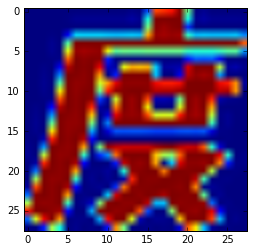

In [21]:
#display the image from ndarray
#from IPython.display import display,Image
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt
folder = train_folders[0]
print folder
for image in os.listdir(folder)[0:3]:
    image = os.path.join(folder, image)
    print image
    image_data = (ndimage.imread(image).astype(float)-pixel_depth / 2) / pixel_depth
    #img = Image.fromarray(image_data)
    #print image_data
    plt.imshow(image_data)

In [13]:
#shuffling the dataset
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

# problem 3
Convince yourself that the data is still good after shuffling!

In [14]:
# Judge whether the datasets are still good or not 


# problem 4
Another check: we expect the data to be balanced across classes. Verify that.

In [15]:
#verify the distribution of  classes
dist = {}
def verify(dataset):
    for ds in dataset:
        if dist.get(ds)==None:
            dist[ds]=0
        else:
            dist[ds]= dist[ds]+1
    return dist
print verify(train_labels)


{0: 52908, 1: 52910, 2: 52911, 3: 52910, 4: 52911, 5: 52911, 6: 52911, 7: 52911, 8: 52911, 9: 52910}


In [16]:
#verify the distribution of  classes
dist = {}
def verify(dataset):
    for ds in dataset:
        if dist.get(ds)==None:
            dist[ds]=0
        else:
            dist[ds]= dist[ds]+1
    return dist
print verify(train_labels)
print verify(test_labels)

{0: 52908, 1: 52910, 2: 52911, 3: 52910, 4: 52911, 5: 52911, 6: 52911, 7: 52911, 8: 52911, 9: 52910}
{0: 54780, 1: 54783, 2: 54784, 3: 54783, 4: 54784, 5: 54783, 6: 54783, 7: 54783, 8: 54783, 9: 54782}


In [17]:
#divide dataset into train_set and valid_set
train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape

Training (200000, 28, 28) (200000,)
Validation (10000, 28, 28) (10000,)


In [18]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 718193801


# problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples. Optional questions:
* What about near duplicates between datasets? (images that are almost identical)
* Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [19]:
#compute the overlap of each datasets with each other

def OL_Comp(dataset_1, dataset_2):
    sum = 0
    #Combine two ndarray
    dataset = np.vstack([dataset_1,dataset_2])
    #platten each element and put them into list
    dataset = [d.flatten() for d in dataset]
    #convert list into np.array
    temp = np.array(dataset)
    #to be hashable
    new = np.vstack({tuple(row) for row in temp})
    if dataset_1.shape[0]>=dataset_2.shape[0]:
        sum = new.shape[0]-dataset_1.shape[0]
    else:
        sum = new.shape[0]-dataset_2.shape[0]
    return sum

# file = open('notMNIST.pickle','r')
# data_stream = pickle.load(file)
train_dataset = save['train_dataset']
valid_dataset = save['valid_dataset']
print 'train_dataset '+'overlaps'+' valid_dataset', OL_Comp(train_dataset,valid_dataset)
print 'train_dataset '+'overlaps'+' test_dataset', OL_Comp(train_dataset,test_dataset)
print 'test_dataset '+'overlaps'+' valid_dataset', OL_Comp(test_dataset,valid_dataset)

train_dataset overlaps valid_dataset -3735
train_dataset overlaps test_dataset 3495
test_dataset overlaps valid_dataset 9222


# Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.
Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.
Optional question: train an off-the-shelf model on all the data!


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import random

In [69]:
index_train = np.random.randint(0,len(train_dataset),50)
index_test = np.random.randint(0,len(test_dataset),100)

## 1. Size 50

In [94]:
# random sample
def validation(train_dataset, test_dataset, train_labels, test_labels, sampling_train, sampling_test):
    index_train = np.random.randint(0,len(train_dataset),sampling_train)
    index_test = np.random.randint(0,len(test_dataset),sampling_test)

    X_train= train_dataset[index_train]
    y_train = train_labels[index_train]


    X_test = test_dataset[index_test]
    y_test = test_labels[index_test]

    X_train = np.array([i.flatten() for i in X_train])
    X_test = np.array([i.flatten() for i in X_test])

    linreg = LinearRegression()

    #trainning
    linreg.fit(X_train,y_train)

    #Test
    y_pred = linreg.predict(X_test)

    # calculate MSE 
    mse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
    return mse

In [121]:
# validation
mse_array=[]
times = np.arange(100,10001,100)

In [122]:
for t in times:
    mse = validation(train_dataset,test_dataset,train_labels,test_labels,t,100)
    mse_array.append(mse)

In [123]:
print mse_array

[2.8056471168494399, 2.7921393533143162, 3.5795919967112417, 2.7904102123232568, 63.153751821892683, 5.4304613313264012, 28.500492569154598, 13.598300036689816, 5.3986135623363829, 4.7030932193857806, 2.9011190141062597, 3.2448659623654779, 2.9525884272529428, 2.8573839457148003, 3.0662443223041302, 2.3646602791379125, 2.3992167029340274, 2.666300369023932, 2.0045122940995808, 2.7205492815544212, 2.1565260320034971, 2.2365047411003687, 1.9727993890928537, 2.1807179513553021, 2.2137573355476472, 2.1748444114597953, 2.0492066301542975, 2.0845794240271229, 2.5686863565183655, 2.0859595097200834, 2.3174097648919409, 2.0369982469630616, 2.4512800563275947, 2.2151488281823726, 1.7715004636754714, 1.8808931798113246, 2.1205792533162544, 1.8589709157709657, 2.2585043061018961, 2.2089182360876807, 1.9981850706064066, 1.9601601003399807, 1.911620148840625, 1.9715896718822665, 1.8474490790635725, 1.9876449451341531, 2.0245899361545407, 1.7365701706779582, 2.035448934742329, 2.1631602177694584, 2.

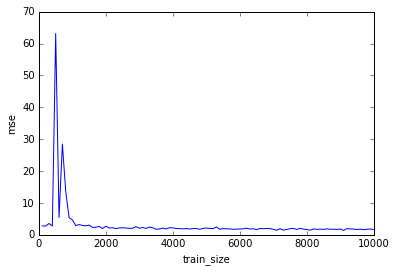

In [124]:
plt.plot(times,mse_array)
plt.xlabel("train_size")
plt.ylabel("mse")